<a href="https://colab.research.google.com/github/Will-Trinh/CECS456/blob/main/456project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Copy the zip file from Drive to Colab (Faster processing)
!cp "/content/drive/MyDrive/animals_data.zip" .

# 3. Unzip the dataset
!unzip -q animals_data.zip -d dataset_root

print("Data successfully loaded!")

Mounted at /content/drive
Data successfully loaded!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define setup variables
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
DATA_DIR = "dataset_root/raw-img" # The unzipped folder name usually contains 'raw-img'

# Load Training Data (80% split)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load Validation Data (20% split)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Print class names for your report
class_names = train_ds.class_names
print(f"Classes found: {class_names}")

# Performance optimization (keeps data in memory)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [ ]:
# Build the CNN Model
model = keras.Sequential([
    # Input Layer & Rescaling (Normalizing pixel values 0-1)
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),

    # Convolutional Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolutional Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Convolutional Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Flatten & Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Critical for "Analysis" points (reduces overfitting)
    layers.Dense(len(class_names), activation='softmax') # Output layer
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,970 (16.36 MB)

 Trainable params: 4,288,970 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.2490 - loss: 2.1114 - val_accuracy: 0.4491 - val_loss: 1.6104
Epoch 2/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4321 - loss: 1.6397 - val_accuracy: 0.5360 - val_loss: 1.3566
Epoch 3/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5152 - loss: 1.4148 - val_accuracy: 0.5786 - val_loss: 1.2152
Epoch 4/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5745 - loss: 1.2408 - val_accuracy: 0.6139 - val_loss: 1.1182
Epoch 5/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6062 - loss: 1.1221 - val_accuracy: 0.6374 - val_loss: 1.0765
Epoch 6/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6536 - loss: 0.9845 - val_accuracy: 0.6499 - val_loss: 1.0543
Epoch 7/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6958 - loss: 0.8778 - val_accuracy: 0.6564 - val_loss: 1.0743
Epoch 8/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7342 - loss: 0.7652 - 

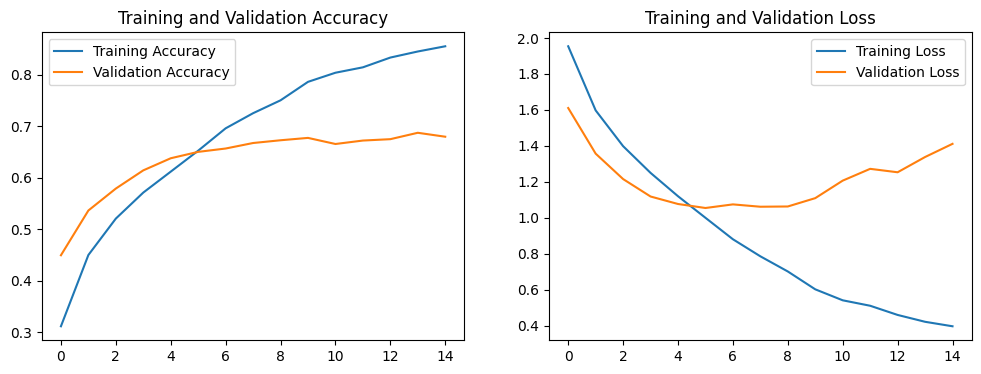

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions for the Validation Set
print("Generating predictions... this may take a moment.")
val_images = []
val_labels = []

# Loop through the validation set to get all images and true labels
for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict
predictions = model.predict(val_images)
predicted_labels = np.argmax(predictions, axis=1)

# 2. Plot Confusion Matrix
cm = confusion_matrix(val_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Where did the model fail?)')
plt.show()

# 3. Print Classification Report (Precision/Recall per animal)
print(classification_report(val_labels, predicted_labels, target_names=class_names))

Generating predictions... this may take a moment.
